In [1]:
from tqdm import tqdm
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 8 GPU(s) available.
Device name: NVIDIA A100-SXM4-40GB


In [ ]:
!nvidia-smi

In [3]:
device = torch.device("cpu")
print("Using CPU for now since all GPUs are full.")


Using CPU for now since all GPUs are full.


In [4]:
from pathlib import Path
import pandas as pd

# ✅ Set your base path
base_path = Path("//data/horse/ws/anpa439f-Function_Retrieval_Citation/Research_Project/classification_data/acl-arc")

# ✅ Define label mapping
label_map = {
    0: "background",
    1: "uses",
    2: "compares",
    3: "motivation",
    4: "continuation",
    5: "future"
}

# ✅ Generic loader function
def load_acl_arc_dataset(csv_path):
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')

    # Map labels from int to string
    df["label"] = df["intent"].map(label_map)
    df = df.dropna(subset=["label"])

    X = df["cleaned_cite_text"].astype(str).tolist()
    y = df["label"].tolist()
    return X, y

In [5]:

X_train, y_train = load_acl_arc_dataset(base_path / "train_30_percent.csv")
X_val, y_val     = load_acl_arc_dataset(base_path / "val_30_percent.csv")
X_test, y_test   = load_acl_arc_dataset(base_path / "test_30_percent.csv")

# ✅ Sanity check
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print("Sample label distribution (train):", pd.Series(y_train).value_counts())


Train: 506, Val: 34, Test: 41
Sample label distribution (train): background      260
uses             95
compares         91
continuation     23
motivation       19
future           18
Name: count, dtype: int64


In [6]:
"""#Load 30 % data

import pandas as pd
from sklearn.model_selection import train_test_split

# Load and combine the existing 30% datasets
df_train = pd.read_csv(base_path / "train_30_percent.csv")
df_val   = pd.read_csv(base_path / "val_30_percent.csv")
df_test  = pd.read_csv(base_path / "test_30_percent.csv")

# Combine all into one for stratified resplit
df = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Stratified split (70% train, 15% val, 15% test)
X = df['text']
y = df['intent']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

# ✅ Optional: print for sanity
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print("Sample label distribution (train):")
print(pd.Series(y_train).value_counts())"""

#Load all data

import pandas as pd
from sklearn.model_selection import train_test_split

# ----------- PATHS -----------
data_dir = "/data/horse/ws/anpa439f-Function_Retrieval_Citation/Research_Project/classification_data/acl-arc"
train_files = ["train_10_percent.csv", "train_20_percent.csv", "train_30_percent.csv"]
val_files = ["val_10_percent.csv", "val_20_percent.csv", "val_30_percent.csv"]
test_files = ["test_10_percent.csv", "test_20_percent.csv", "test_30_percent.csv"]

# ----------- LOAD & COMBINE ALL CSVs -----------
df_all = pd.concat(
    [pd.read_csv(f"{data_dir}/{f}") for f in train_files + val_files + test_files],
    ignore_index=True
)

# ----------- CLEAN TEXT & LABELS -----------
X = df_all["cleaned_cite_text"].astype(str)
y = df_all["intent"].astype(int)

# ----------- STRATIFIED SPLIT: 70% train, 15% val, 15% test -----------
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

# ----------- OPTIONAL: SANITY CHECK -----------
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print("Train label distribution:\n", pd.Series(y_train).value_counts())


Train: 811, Val: 174, Test: 174
Train label distribution:
 intent
0    417
1    152
2    146
4     38
3     29
5     29
Name: count, dtype: int64


In [7]:
from transformers import BertTokenizer
import torch

# Load tokenizer and add special token
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", do_lower_case=True)
tokenizer.add_tokens(['<cite>'])

MAX_LEN = 256

def tokenize_fast(text_list):
    encoded = tokenizer.batch_encode_plus(
        text_list,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='pt'  # PyTorch tensors directly
    )
    return encoded['input_ids'], encoded['attention_mask'], encoded['token_type_ids']


/home/anpa439f/anaconda3/envs/myenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
print("Tokenizing datasets...")

train_inputs, train_masks, train_token_type = tokenize_fast(X_train)
val_inputs, val_masks, val_token_type = tokenize_fast(X_val)
test_inputs, test_masks, test_token_type = tokenize_fast(X_test)

Tokenizing datasets...


In [9]:
y_train_encoded = torch.tensor(list(y_train))
y_val_encoded   = torch.tensor(list(y_val))
y_test_encoded  = torch.tensor(list(y_test))


In [10]:
print(type(X_train))

print("Train labels:", set(y_train))
print("Val labels:", set(y_val))
print("Test labels:", set(y_test))

<class 'pandas.core.series.Series'>
Train labels: {0, 1, 2, 3, 4, 5}
Val labels: {0, 1, 2, 3, 4, 5}
Test labels: {0, 1, 2, 3, 4, 5}


In [11]:
from collections import Counter
import numpy as np
import torch

# Get class counts from encoded labels
label_counts = Counter(y_train_encoded.tolist())
num_classes = len(label_counts)

# Inverse frequency weighting
class_freq = np.array([label_counts[i] for i in range(num_classes)])
class_weights = 1. / class_freq
print("Class weights:", class_weights)


Class weights: [0.00239808 0.00657895 0.00684932 0.03448276 0.02631579 0.03448276]


In [12]:
# Map each training example to its corresponding class weight
samples_weight = np.array([class_weights[label.item()] for label in y_train_encoded])
samples_weight = torch.tensor(samples_weight, dtype=torch.float)

print("Sample weight vector shape:", samples_weight.shape)


Sample weight vector shape: torch.Size([811])


In [13]:
from torch.utils.data import TensorDataset

# Wrap each dataset with its input + attention + token type + label
train_dataset = TensorDataset(train_inputs, train_masks, train_token_type, y_train_encoded)
val_dataset   = TensorDataset(val_inputs, val_masks, val_token_type, y_val_encoded)
test_dataset  = TensorDataset(test_inputs, test_masks, test_token_type, y_test_encoded)


In [14]:
from torch.utils.data import DataLoader, WeightedRandomSampler, SequentialSampler

batch_size = 32

# Balanced sampler for training
train_sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)

# Sequential sampler for val/test (no randomness)
val_sampler = SequentialSampler(val_dataset)
test_sampler = SequentialSampler(test_dataset)

# DataLoaders
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
val_dataloader   = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)
test_dataloader  = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)


In [15]:
print("Train batches:", len(train_dataloader))
example = next(iter(train_dataloader))
print("Example batch input shape:", example[0].shape)
print("Example labels:", example[-1])


Train batches: 26
Example batch input shape: torch.Size([32, 256])
Example labels: tensor([1, 0, 0, 1, 1, 4, 1, 1, 5, 0, 2, 2, 2, 3, 1, 4, 4, 2, 1, 2, 1, 5, 1, 0,
        4, 5, 5, 2, 3, 4, 1, 2])


In [16]:
import torch
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

def initialize_model(epochs=10):
    model = BertForSequenceClassification.from_pretrained(
        "allenai/scibert_scivocab_uncased",
        num_labels=6,  # ⚠️ You have 6 labels
        output_attentions=False,
        output_hidden_states=False
    )
    model.resize_token_embeddings(len(tokenizer))
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    return model, optimizer, scheduler

model, optimizer, scheduler = initialize_model()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 31091. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
/home/anpa439f/anaconda3/envs/myenv/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.Ad

In [ ]:
from tqdm import tqdm

In [22]:

# Helper to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1)
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

loss_fn = nn.CrossEntropyLoss()

def train(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=4, patience=2):

    best_val_loss = float('inf')
    counter = 0
    history = []
    
    for epoch in range(epochs):
        print(f"\n======== Epoch {epoch+1} / {epochs} ========")

        # ---------- Training ----------
        model.train()
        total_loss = 0
        train_steps = 0

        for batch in tqdm(train_dataloader, desc="Training"):
            b_input_ids, b_input_mask, b_token_type_ids, b_labels = [t.to(device) for t in batch]

            model.zero_grad()

            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
                token_type_ids=b_token_type_ids,
                labels=b_labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            train_steps += 1

        avg_train_loss = total_loss / train_steps
        print(f"\n✅ Average training loss: {avg_train_loss:.4f}")

        # ---------- Validation ----------
        model.eval()
        val_loss = 0
        val_accuracy = 0
        nb_eval_steps = 0

        for batch in tqdm(val_dataloader, desc="Validation"):
            b_input_ids, b_input_mask, b_token_type_ids, b_labels = [t.to(device) for t in batch]

            with torch.no_grad():
                outputs = model(
                    input_ids=b_input_ids,
                    attention_mask=b_input_mask,
                    token_type_ids=b_token_type_ids,
                    labels=b_labels
                )

            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            val_accuracy += flat_accuracy(logits, label_ids)
            nb_eval_steps += 1

        avg_val_loss = val_loss / nb_eval_steps
        avg_val_accuracy = val_accuracy / nb_eval_steps

        print(f"✅ Validation loss: {avg_val_loss:.4f}")
        print(f"✅ Validation accuracy: {avg_val_accuracy:.4f}")
        # Log history
        history.append({
            "epoch": epoch+1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_accuracy": avg_val_accuracy
        })

        # ---------- Early stopping and saving best model ----------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            output_dir = "scibert_6label_model_60_data"
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            model.save_pretrained(output_dir)
            tokenizer.save_pretrained(output_dir)
            print("💾 Saved new best model.")
        else:
            counter += 1
            if counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    # Save training log
    pd.DataFrame(history).to_csv("training_log.csv", index=False)
    print("📝 Training log saved to training_log.csv")


In [23]:
train(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=10)



======== Epoch 1 / 10 ========


Training: 100%|██████████| 26/26 [13:18<00:00, 30.70s/it]



✅ Average training loss: 1.2555


Validation: 100%|██████████| 6/6 [00:49<00:00,  8.23s/it]


✅ Validation loss: 1.2549
✅ Validation accuracy: 0.5938
💾 Saved new best model.

======== Epoch 2 / 10 ========


Training: 100%|██████████| 26/26 [13:32<00:00, 31.25s/it]



✅ Average training loss: 0.9534


Validation: 100%|██████████| 6/6 [00:48<00:00,  8.10s/it]


✅ Validation loss: 1.0072
✅ Validation accuracy: 0.6607
💾 Saved new best model.

======== Epoch 3 / 10 ========


Training: 100%|██████████| 26/26 [14:26<00:00, 33.32s/it]



✅ Average training loss: 0.6801


Validation: 100%|██████████| 6/6 [00:48<00:00,  8.08s/it]


✅ Validation loss: 0.8546
✅ Validation accuracy: 0.7195
💾 Saved new best model.

======== Epoch 4 / 10 ========


Training: 100%|██████████| 26/26 [15:14<00:00, 35.18s/it]



✅ Average training loss: 0.4996


Validation: 100%|██████████| 6/6 [00:55<00:00,  9.18s/it]


✅ Validation loss: 0.7590
✅ Validation accuracy: 0.7679
💾 Saved new best model.

======== Epoch 5 / 10 ========


Training: 100%|██████████| 26/26 [15:46<00:00, 36.42s/it]



✅ Average training loss: 0.4087


Validation: 100%|██████████| 6/6 [00:54<00:00,  9.05s/it]


✅ Validation loss: 0.6587
✅ Validation accuracy: 0.7768
💾 Saved new best model.

======== Epoch 6 / 10 ========


Training: 100%|██████████| 26/26 [15:05<00:00, 34.83s/it]



✅ Average training loss: 0.3389


Validation: 100%|██████████| 6/6 [00:58<00:00,  9.83s/it]


✅ Validation loss: 0.5816
✅ Validation accuracy: 0.8028
💾 Saved new best model.

======== Epoch 7 / 10 ========


Training: 100%|██████████| 26/26 [13:23<00:00, 30.92s/it]



✅ Average training loss: 0.2776


Validation: 100%|██████████| 6/6 [00:42<00:00,  7.00s/it]


✅ Validation loss: 0.5704
✅ Validation accuracy: 0.8185
💾 Saved new best model.

======== Epoch 8 / 10 ========


Training: 100%|██████████| 26/26 [13:13<00:00, 30.51s/it]



✅ Average training loss: 0.2678


Validation: 100%|██████████| 6/6 [00:55<00:00,  9.27s/it]


✅ Validation loss: 0.5481
✅ Validation accuracy: 0.7976
💾 Saved new best model.

======== Epoch 9 / 10 ========


Training: 100%|██████████| 26/26 [14:24<00:00, 33.25s/it]



✅ Average training loss: 0.2346


Validation: 100%|██████████| 6/6 [00:49<00:00,  8.22s/it]


✅ Validation loss: 0.5416
✅ Validation accuracy: 0.7976
💾 Saved new best model.

======== Epoch 10 / 10 ========


Training: 100%|██████████| 26/26 [12:55<00:00, 29.83s/it]



✅ Average training loss: 0.2259


Validation:  50%|█████     | 3/6 [00:25<00:25,  8.39s/it]

In [19]:
"""model.save_pretrained("scibert_6label_model_30_data")
tokenizer.save_pretrained("scibert_6label_model_30_data")"""

model.save_pretrained("scibert_6label_model_combined_data")
tokenizer.save_pretrained("scibert_6label_model_combined_data")


('scibert_6label_model_combined_data/tokenizer_config.json',
 'scibert_6label_model_combined_data/special_tokens_map.json',
 'scibert_6label_model_combined_data/vocab.txt',
 'scibert_6label_model_combined_data/added_tokens.json')

In [ ]:
# Continue 3 more epochs
# Load saved model and tokenizer

from transformers import AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained("scibert_6label_model_60_data")
tokenizer = AutoTokenizer.from_pretrained("scibert_6label_model_60_data")
model.to(device)

# Reinitialize optimizer and scheduler
epochs_to_run = 3
start_epoch = 10  # We continue from epoch 10
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
total_steps = len(train_dataloader) * epochs_to_run
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(start_epoch, start_epoch + epochs_to_run):
    print(f"\n🚀 Starting Epoch {epoch}...\n")
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc="Training"):
        b_input_ids, b_input_mask, b_token_type_ids, b_labels = [t.to(device) for t in batch]

        model.zero_grad()
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask,
            token_type_ids=b_token_type_ids,
            labels=b_labels
        )

        loss = outputs.loss
        loss.backward()
        total_loss += loss.item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"\n✅ Epoch {epoch} Training Loss: {avg_train_loss:.4f}")

    # Validation
    print("\n🧪 Running validation...")
    model.eval()
    val_loss, val_accuracy, steps = 0, 0, 0

    for batch in tqdm(val_dataloader, desc="Validation"):
        b_input_ids, b_input_mask, b_token_type_ids, b_labels = [t.to(device) for t in batch]

        with torch.no_grad():
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
                token_type_ids=b_token_type_ids,
                labels=b_labels
            )
            loss = outputs.loss
            logits = outputs.logits

        val_loss += loss.item()
        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        labels = b_labels.cpu().numpy()
        val_accuracy += np.sum(preds == labels) / len(labels)
        steps += 1

    print(f"✅ Epoch {epoch} Validation Loss: {val_loss/steps:.4f}")
    print(f"✅ Epoch {epoch} Validation Accuracy: {val_accuracy/steps:.4f}")



🚀 Starting Epoch 10...



Training: 100%|██████████| 26/26 [17:33<00:00, 40.51s/it]



✅ Epoch 10 Training Loss: 0.2247

🧪 Running validation...


Validation: 100%|██████████| 6/6 [00:52<00:00,  8.75s/it]


✅ Epoch 10 Validation Loss: 0.5126
✅ Epoch 10 Validation Accuracy: 0.8653

🚀 Starting Epoch 11...



Training: 100%|██████████| 26/26 [16:16<00:00, 37.57s/it]



✅ Epoch 11 Training Loss: 0.1422

🧪 Running validation...


Validation: 100%|██████████| 6/6 [00:52<00:00,  8.67s/it]


✅ Epoch 11 Validation Loss: 0.4634
✅ Epoch 11 Validation Accuracy: 0.8326

🚀 Starting Epoch 12...



Training: 100%|██████████| 26/26 [16:03<00:00, 37.07s/it]



✅ Epoch 12 Training Loss: 0.1117

🧪 Running validation...


Validation: 100%|██████████| 6/6 [00:54<00:00,  9.03s/it]

✅ Epoch 12 Validation Loss: 0.4519
✅ Epoch 12 Validation Accuracy: 0.8497


In [27]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("scibert_6label_model_combined_data")
tokenizer = AutoTokenizer.from_pretrained("scibert_6label_model_combined_data")
model.to(device)



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31091, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
id2label = {
    0: "background",
    1: "uses",
    2: "compares",
    3: "continuation",
    4: "motivation",
    5: "future"
}
label2id = {v: k for k, v in id2label.items()}

model.config.id2label = id2label
model.config.label2id = label2id

In [18]:
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained("scibert_6label_model_combined_data")
tokenizer = BertTokenizer.from_pretrained("scibert_6label_model_combined_data")

# Manually set correct label mapping
model.config.id2label = {
    0: "background",
    1: "uses",
    2: "compares",
    3: "continuation",
    4: "motivation",
    5: "future"
}
model.config.label2id = {v: k for k, v in model.config.id2label.items()}


In [19]:
# 
def predict_citation_function(text):
    model.eval()
    encoded = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=256)
    encoded = {k: v.to(device) for k, v in encoded.items()}
    with torch.no_grad():
        logits = model(**encoded).logits
    pred = torch.argmax(logits, dim=1).item()
    return id2label[pred]


In [32]:
print(predict_citation_function("We use the dataset proposed by Zhang et al. (2019)."))
# Expected: uses

print(predict_citation_function("Previous work has shown that attention improves performance (Bahdanau et al., 2014)."))
# Expected: background

print(predict_citation_function("Unlike Smith et al. (2018), our method does not require pretraining."))
# Expected: compares

print(predict_citation_function("Neural networks have been widely used for text classification since the work of Kim (2014)."))
# Expected: background

print(predict_citation_function("Attention mechanisms were first introduced by Bahdanau et al. (2014) for machine translation."))
# Expected: background

print(predict_citation_function("We implement our model using the HuggingFace Transformers library (Wolf et al., 2020)."))
# Expected: uses

print(predict_citation_function("Our results are evaluated using the same metrics as defined in (Lin, 2004)."))
# Expected: uses

print(predict_citation_function("In contrast to Lee et al. (2019), our model does not rely on handcrafted features."))
# Expected: compares

print(predict_citation_function("Unlike BERT-based models (Devlin et al., 2019), our system uses no pretraining."))
# Expected: compares

print(predict_citation_function("This builds on the findings of Xu et al. (2021), who first applied contrastive loss in this context."))
# Expected: continuation

print(predict_citation_function("Our work extends the dialogue framework proposed in (Ritter et al., 2011)."))
# Expected: continuation

print(predict_citation_function("While recent models achieve high accuracy, they require large computational resources (Brown et al., 2020)."))
# Expected: motivation

print(predict_citation_function("Despite promising results from prior work (Yin et al., 2017), scalability remains an issue."))
# Expected: motivation
print(predict_citation_function("Future work could explore integrating multimodal inputs as done in (Zellers et al., 2021)."))
# Expected: future

print(predict_citation_function("We plan to investigate the use of reinforcement learning for this task, inspired by (Silver et al., 2016)."))
# Expected: future




uses
background
continuation
background
background
continuation
continuation
continuation
uses
compares
continuation
background
background
future
future


In [29]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import torch
import numpy as np

# Load model and tokenizer from the epoch 12 checkpoint
model = AutoModelForSequenceClassification.from_pretrained("scibert_6label_model_ep12")
tokenizer = AutoTokenizer.from_pretrained("scibert_6label_model_ep12")
model.to(device)
model.train()

# Reinitialize optimizer and scheduler for 2 more epochs
epochs = 2
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training for 2 more epochs
def resume_n_epochs(model, train_dataloader, val_dataloader, optimizer, scheduler, start_epoch, n_epochs):
    for ep in range(start_epoch, start_epoch + n_epochs):
        print(f"\n🚀 Starting Epoch {ep}...\n")
        model.train()
        total_loss = 0

        for batch in tqdm(train_dataloader, desc="Training"):
            b_input_ids, b_input_mask, b_token_type_ids, b_labels = [t.to(device) for t in batch]

            model.zero_grad()
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
                token_type_ids=b_token_type_ids,
                labels=b_labels
            )

            loss = outputs.loss
            loss.backward()
            total_loss += loss.item()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"\n✅ Epoch {ep} Training Loss: {avg_train_loss:.4f}")

        # Validation
        print("\n🧪 Running validation...")
        model.eval()
        val_loss, val_accuracy, steps = 0, 0, 0

        for batch in tqdm(val_dataloader, desc="Validation"):
            b_input_ids, b_input_mask, b_token_type_ids, b_labels = [t.to(device) for t in batch]

            with torch.no_grad():
                outputs = model(
                    input_ids=b_input_ids,
                    attention_mask=b_input_mask,
                    token_type_ids=b_token_type_ids,
                    labels=b_labels
                )
                loss = outputs.loss
                logits = outputs.logits

            val_loss += loss.item()
            preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
            labels = b_labels.cpu().numpy()
            val_accuracy += np.sum(preds == labels) / len(labels)
            steps += 1

        print(f"✅ Epoch {ep} Validation Loss: {val_loss/steps:.4f}")
        print(f"✅ Epoch {ep} Validation Accuracy: {val_accuracy/steps:.4f}")

# Call the function
resume_n_epochs(model, train_dataloader, val_dataloader, optimizer, scheduler, start_epoch=13, n_epochs=2)


/home/anpa439f/anaconda3/envs/myenv/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



🚀 Starting Epoch 13...



Training: 100%|██████████| 26/26 [15:26<00:00, 35.62s/it]



✅ Epoch 13 Training Loss: 0.0988

🧪 Running validation...


Validation: 100%|██████████| 6/6 [00:52<00:00,  8.70s/it]


✅ Epoch 13 Validation Loss: 0.4677
✅ Epoch 13 Validation Accuracy: 0.8549

🚀 Starting Epoch 14...



Training:   4%|▍         | 1/26 [00:42<17:37, 42.31s/it]


KeyboardInterrupt: 

In [22]:
model.save_pretrained("scibert_6label_model_ep12")
tokenizer.save_pretrained("scibert_6label_model_ep12")


('scibert_6label_model_ep12/tokenizer_config.json',
 'scibert_6label_model_ep12/special_tokens_map.json',
 'scibert_6label_model_ep12/vocab.txt',
 'scibert_6label_model_ep12/added_tokens.json',
 'scibert_6label_model_ep12/tokenizer.json')

In [25]:
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained("scibert_6label_model_ep12")
tokenizer = BertTokenizer.from_pretrained("scibert_6label_model_ep12")

# Manually set correct label mapping
model.config.id2label = {
    0: "background",
    1: "uses",
    2: "compares",
    3: "continuation",
    4: "motivation",
    5: "future"
}
model.config.label2id = {v: k for k, v in model.config.id2label.items()}


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

for batch in test_dataloader:
    b_input_ids, b_input_mask, b_token_type_ids, b_labels = [t.to(device) for t in batch]

    with torch.no_grad():
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask,
            token_type_ids=b_token_type_ids
        )

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    label_ids = b_labels.cpu().numpy()

    all_preds.extend(preds)
    all_labels.extend(label_ids)

# Map label IDs to names
id2label = {v: k for k, v in label2id.items()}
target_names = [id2label[i] for i in range(len(label2id))]

# Print classification report
print("📊 Classification Report on Test Set")
print(classification_report(all_labels, all_preds, target_names=target_names))


📊 Classification Report on Test Set
              precision    recall  f1-score   support

  background       0.92      0.92      0.92        90
        uses       0.88      0.88      0.88        33
    compares       0.72      0.74      0.73        31
continuation       1.00      0.67      0.80         6
  motivation       0.56      0.62      0.59         8
      future       1.00      1.00      1.00         6

    accuracy                           0.86       174
   macro avg       0.85      0.81      0.82       174
weighted avg       0.87      0.86      0.86       174



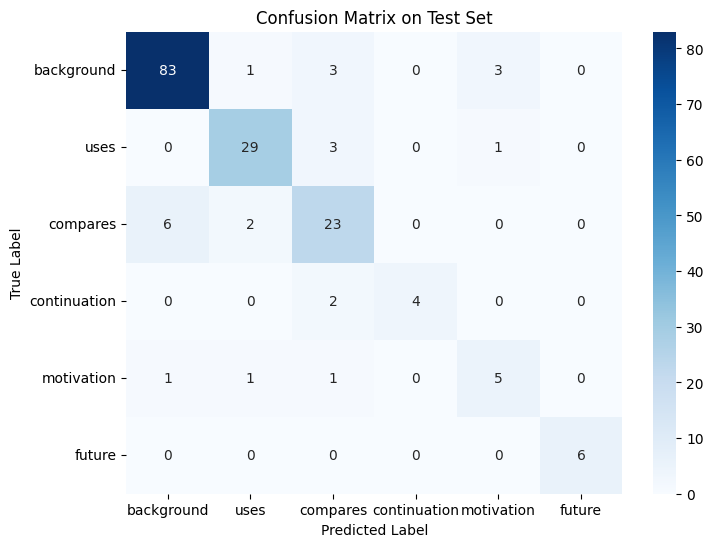

In [28]:
#Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


In [35]:
import torch.nn.functional as F

def print_softmax_for_compares(X_test, y_test, tokenizer, model, device):
    print("🧪 Confidence scores for `compares` test examples:\n")
    compares_label_id = label2id["compares"]

    for i, (text, true_label) in enumerate(zip(X_test, y_test)):
        if true_label != "compares":
            continue

        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=256
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            logits = model(**inputs).logits
            probs = F.softmax(logits, dim=1).squeeze().cpu().numpy()
            pred_id = int(torch.argmax(logits, dim=1).cpu().item())

        sorted_probs = sorted([(i, p) for i, p in enumerate(probs)], key=lambda x: x[1], reverse=True)
        top_2 = sorted_probs[:2]

        print(f"📝 Example {i+1}:")
        print(f"Text: {text[:150]}{'...' if len(text) > 150 else ''}")
        print(f"True label: compares")
        print(f"Predicted label: {id2label[pred_id]}")
        print("Confidence scores:")
        for idx, score in enumerate(probs):
            print(f"  {id2label[idx]:>12}: {score:.4f}")
        print(f"🔥 Top 2 predictions: {[(id2label[i], f'{p:.2f}') for i, p in top_2]}")
        print("-" * 60)


In [37]:
import torch.nn.functional as F

def collect_softmax_for_all(X_test, y_test, tokenizer, model, device):
    results = []

    for i, (text, true_label) in enumerate(zip(X_test, y_test)):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            logits = model(**inputs).logits
            probs = F.softmax(logits, dim=1).squeeze().cpu().numpy()
            pred_id = int(torch.argmax(logits, dim=1).cpu().item())

        sorted_probs = sorted([(j, p) for j, p in enumerate(probs)], key=lambda x: x[1], reverse=True)
        top_2 = [(id2label[j], float(f"{p:.4f}")) for j, p in sorted_probs[:2]]

        result = {
            "example_index": i + 1,
            "text": text,
            "true_label": id2label[true_label],
            "predicted_label": id2label[pred_id],
            "top_2_predictions": top_2
        }

        results.append(result)

    return results


In [38]:
import pandas as pd

results_list = collect_softmax_for_all(X_test, y_test, tokenizer, model, device)

df = pd.DataFrame([
    {
        "Example": r["example_index"],
        "True Label": r["true_label"],
        "Predicted Label": r["predicted_label"],
        "Top 1": f"{r['top_2_predictions'][0][0]} ({r['top_2_predictions'][0][1]:.2f})",
        "Top 2": f"{r['top_2_predictions'][1][0]} ({r['top_2_predictions'][1][1]:.2f})",
        "Text": r["text"][:100] + ("..." if len(r["text"]) > 100 else "")
    }
    for r in results_list
])

# Display the table in Jupyter Notebook
display(df)


,Example,True Label,Predicted Label,Top 1,Top 2,Text
0,1,background,background,background (0.58),compares (0.22),â¢ Learnability ( Zernik and Dyer 1987 ) â¢ ...
1,2,continuation,continuation,continuation (0.31),uses (0.20),"Previously ( @@CITATION ) , we assessed the im..."
2,3,uses,uses,uses (0.60),background (0.14),"To build the above s2t system , we first use t..."
3,4,background,background,background (0.58),compares (0.16),This system has been successfully tested with ...
4,5,uses,background,background (0.41),uses (0.28),A statistical technique which has recently bec...
...,...,...,...,...,...,...
169,170,background,compares,compares (0.39),background (0.31),This is the strongest version of the sorites p...
170,171,compares,compares,compares (0.54),background (0.23),This was done because purely unsupervised tech...
171,172,background,background,background (0.66),compares (0.15),Discriminative approaches ( especially SVMs ) ...
172,173,uses,uses,uses (0.55),background (0.15),Other molecular biology databases We also incl...


In [39]:
df.to_csv("test_predictions.csv", index=False)
